In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import sici
from scipy.integrate import quad
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]
})

In [2]:
common_settings = {
'omega_b':0.022,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
}
def g_an(t):
    return  1 + 6 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[1] - 3 * np.exp(-t) * np.pi * np.sin(np.sqrt(6) * np.exp(-t / 2)) + 6 * np.exp(-t) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]
def h_an(t):
    return 1 + 3 * np.sqrt(3 / 2) * np.exp(-3 * t / 2) * np.pi * np.cos(np.sqrt(6) * np.exp(-t / 2)) - 3 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2))**2 + 3 * np.sqrt(6) * np.exp(-3 * t / 2) * sici(np.sqrt(6) * np.exp(-t / 2))[1] * np.sin(np.sqrt(6) * np.exp(-t / 2)) - 3 * np.sqrt(6) * np.exp(-3 * t / 2) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * np.sinc(np.sqrt(6) * np.exp(-t / 2) / np.pi) - 3 * np.sqrt(6) * np.exp(-3 * t / 2) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]


In [3]:
chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
aNR=1.e-3
f_chi=0.1
print(f'aNR={aNR},zNR={1/aNR -1}')
chiCDM.set({
# 'N_ur': 3.046,
'omega_cdm':0.12,
# 'omega_cdm':0.08,

'f_chi':f_chi,
'acs_chi':aNR,
'cs2_peak_chi':1./3.,
# 'T_cmb':1.7,
})
chiCDM.compute()



aNR=0.001,zNR=999.0
Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.379258 Gyr
 -> conformal age = 13591.123047 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3771.254146
    corresponding to conformal time = 101.800901 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0478448       , omega = 0.022          
-> Cold Dark Matter               Omega = 0.260972        , omega = 0.12           
-> Dark Matter with sound speed:  Omega = 0.034313        , omega = 0.0157778      
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.71799e-05     , omega = 1.70961e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.656779        , omega = 0.302      

In [4]:
z_ini = 100
z_end = 5
a_ini = 1/(z_ini+1);a_end = 1/(z_end+1)

kk = np.logspace(-3.,0.,100) # k in h/Mpc
Pk_ini = [] # P(k) in (Mpc/h)**3
Pk_end = [] # P(k) in (Mpc/h)**3

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk_ini.append(chiCDM.pk_cb_lin(k*h,z_ini)*h**3) # function .pk(k,z)
    Pk_end.append(chiCDM.pk_cb_lin(k*h,z_end)*h**3) # function .pk(k,z)

Pk_ini=np.array(Pk_ini);Pk_end=np.array(Pk_end)


chi_tk_k = chiCDM.get_transfer(z=z_end)
f_b_overcb = 0.022/(0.12+0.022)
cb_chi = -(1-f_b_overcb)*chi_tk_k['d_cdm']-f_b_overcb*chi_tk_k['d_cdm']
kEval=chi_tk_k['k (h/Mpc)']
ratio_end=-chi_tk_k['d_cdm']/chi_tk_k['d_m']
d_cdm_k=-chi_tk_k['d_cdm']


background = chiCDM.get_background() # load background table
a = 1/(background['z']+1) # read redshift
rho_cdm=background['(.)rho_cdm']
rho_chi=background['(.)rho_chi']
kJ_chi=background['(.)kJ_chi']
D_class_int = interp1d(a,background['gr.fac. D'])
Ha=background['H [1/Mpc]']/(1.+background['z'])
Ha_chi_int=interp1d(a,Ha)
kJ_int=interp1d(a,kJ_chi)

/tmp/ipykernel_2646496/2404127505.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  D_integral, D_error = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-4)


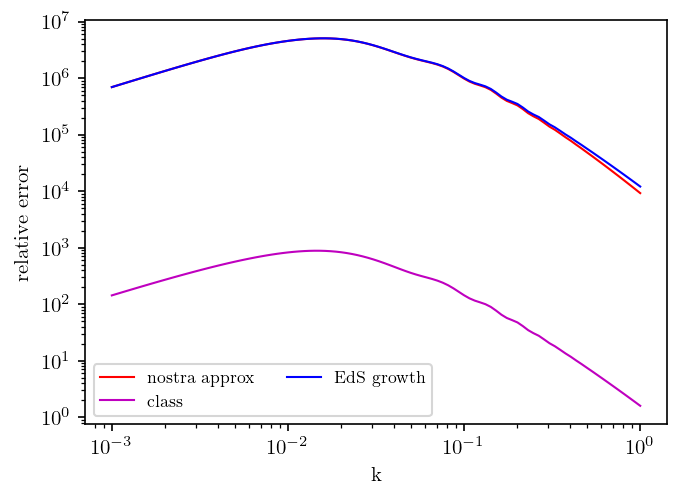

In [25]:
from scipy.integrate import odeint

def s1_system(s1, t):
    ds1dt = -2.5*s1+1.5*(g_an(t)-1)
    return ds1dt
t = np.linspace(-10,25, 100)
sol = odeint(s1_system, -3/5, t)
s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')

D_ini=D_class_int(a_ini);D_end=D_class_int(a_end)

# compute growth factor for every k
Delta_logD_k=[]
adjust=0.
for k in kk:
    te_ini_of_ak=np.log(a_ini/aNR) - 2*np.log(k/kJ_int(aNR)) +adjust
    te_end_of_ak=np.log(a_end/aNR) - 2*np.log(k/kJ_int(aNR))+adjust
    D_integral, D_error = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-4)
    Delta_logD_k.append(D_integral)

D_k = (D_end/D_ini)*np.exp(f_chi*np.array(Delta_logD_k)) 
P_end_D = Pk_ini * D_k**2
# D_EdS = np.exp(np.log(a_end/a_ini) )
D_EdS = D_end/D_ini
P_end_D_EdS = Pk_ini * D_EdS**2

plt.figure(figsize=(5.,3.5), dpi=150)

plt.plot(kk, P_end_D,'r',label=r'nostra approx', linewidth=1.)
plt.plot(kk,Pk_end,'m',label=r'class', linewidth=1.)

plt.plot(kk,P_end_D_EdS,'b',label=r'EdS growth', linewidth=1.)


plt.xscale('log')
plt.yscale('log')
# plt.ylim([3.e-3,1])
plt.xlabel('k')
plt.ylabel('relative error')
plt.legend(loc='best', fontsize=8, ncol=2)

plt.show()

----
now take bacco and put it there

In [6]:
%%capture
import baccoemu
emulator = baccoemu.Matter_powerspectrum();

2025-01-16 13:32:07.322103: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 13:32:07.324092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 13:32:07.364508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 13:32:07.365456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 13:32:08.067882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

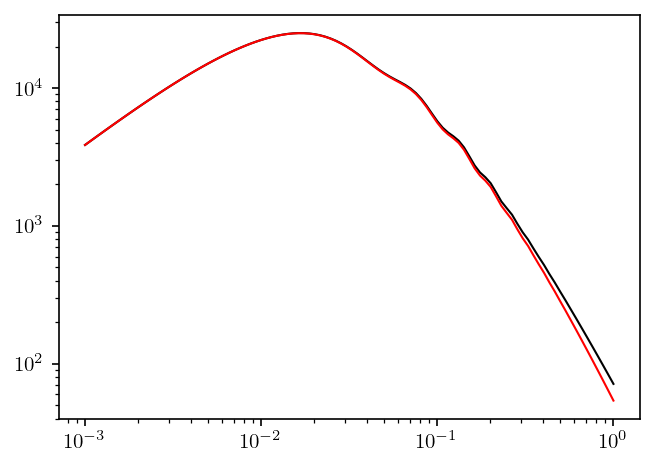

In [33]:
params = {
    'ns'            : 0.9624,
    'A_s'           : 2.13e-09,
    'hubble'        : 0.6711,
    'omega_baryon'  : 0.049,
    'omega_cold'    : 0.3175, # This is Omega_cb!!!
    'neutrino_mass' : 0.,
    'w0'            : -1.,
    'wa'            : 0.,
    'expfactor'     : 1
}

a0p5=1/(1+0.5)
kJ0p5 = 1000
aNR = 0.0321*0.01/kJ0p5

def s1_system(s1, t):
    ds1dt = -2.5*s1+1.5*(g_an(t)-1)
    return ds1dt
t = np.linspace(-10,25, 30000)
sol = odeint(s1_system, -3/5, t)
s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')

def get_an_growthsuppr(kk, a_ini, a_end):
    # compute growth factor for every k
    Delta_logD_k=[]
    for k in kk:
        te_ini_of_ak=np.log(a_ini/a0p5) - 2*np.log(k/kJ0p5)
        te_end_of_ak=np.log(a_end/a0p5) - 2*np.log(k/kJ0p5)
        D_integral, _ = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-2)
        Delta_logD_k.append(D_integral)
    return np.array(Delta_logD_k)

# self.cosmo_arguments['acs_chi'] = 0.0321*0.01/self.cosmo_arguments['kJ0p5']

_, PL = emulator.get_linear_pk(k=kk, cold=True, **params)
plt.figure(figsize=(5.,3.5), dpi=150)

plt.loglog(kk, PL,'k',label=r'bacco end', linewidth=1.)
a_ini=aNR
DbaccoIni=(a_ini)**3

Delta_logD_kbacc=get_an_growthsuppr(kk, aNR, a0p5)
Dbacco_k_from0 = np.exp(f_chi*np.array(Delta_logD_kbacc)) 

plt.loglog(kk, PL*Dbacco_k_from0**2,'r',label=r'bacco ini', linewidth=1.)

plt.show()

In [34]:
%timeit get_an_growthsuppr(kk, a_ini, 1)

47.8 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
